In [70]:
import numpy as np
import pickle
import cv2
import os
from os import listdir
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical

In [71]:
datasetDirectory = '/Users/kartheekkodati/Desktop/final-ML/plantvillage_dataset/segmented/'
width = 150
height = 150
depth = 3
BATCH_SIZE = 32
IMG_SIZE = (width, height)

In [72]:
listdir(datasetDirectory)

['Strawberry___healthy',
 'Grape___Black_rot',
 'Potato___Early_blight',
 'Blueberry___healthy',
 'Corn_(maize)___healthy',
 'Tomato___Target_Spot',
 '.DS_Store',
 'Peach___healthy',
 'Potato___Late_blight',
 'Tomato___Late_blight',
 'Tomato___Tomato_mosaic_virus',
 'Pepper,_bell___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Tomato___Leaf_Mold',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Cherry_(including_sour)___Powdery_mildew',
 'Apple___Cedar_apple_rust',
 'Tomato___Bacterial_spot',
 'Grape___healthy',
 'Tomato___Early_blight',
 'Corn_(maize)___Common_rust_',
 'Grape___Esca_(Black_Measles)',
 'Raspberry___healthy',
 'Tomato___healthy',
 'Cherry_(including_sour)___healthy',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Apple___Apple_scab',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Peach___Bacterial_spot',
 'Pepper,_bell___Bacterial_spot',
 'Tomato___Septoria_leaf_spot',
 'Squash___Powdery_mildew',
 'Corn_(maize)___Ce

In [73]:
image_list, label_list = [], []
for directory in listdir(datasetDirectory):
    if not any([x in directory for x in ["Apple"]]):
            continue
    print(f"Processing {directory} ...")
    plantDiseaseImageList = listdir(f"{datasetDirectory}/{directory}/")
    for plantImage in plantDiseaseImageList[:500]:
        if plantImage == ".DS_Store":
            continue
        imagePath = f"{datasetDirectory}/{directory}/{plantImage}"
        if imagePath.endswith(".jpg") == True or imagePath.endswith(
                ".JPG") == True:
            img = cv2.imread(imagePath, 0)
            img = cv2.resize(img, IMG_SIZE)
            image_list.append(np.asarray(img))
            label_list.append(directory)

Processing Apple___Cedar_apple_rust ...
Processing Apple___Apple_scab ...
Processing Apple___Black_rot ...
Processing Apple___healthy ...


In [74]:
set(label_list)

{'Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy'}

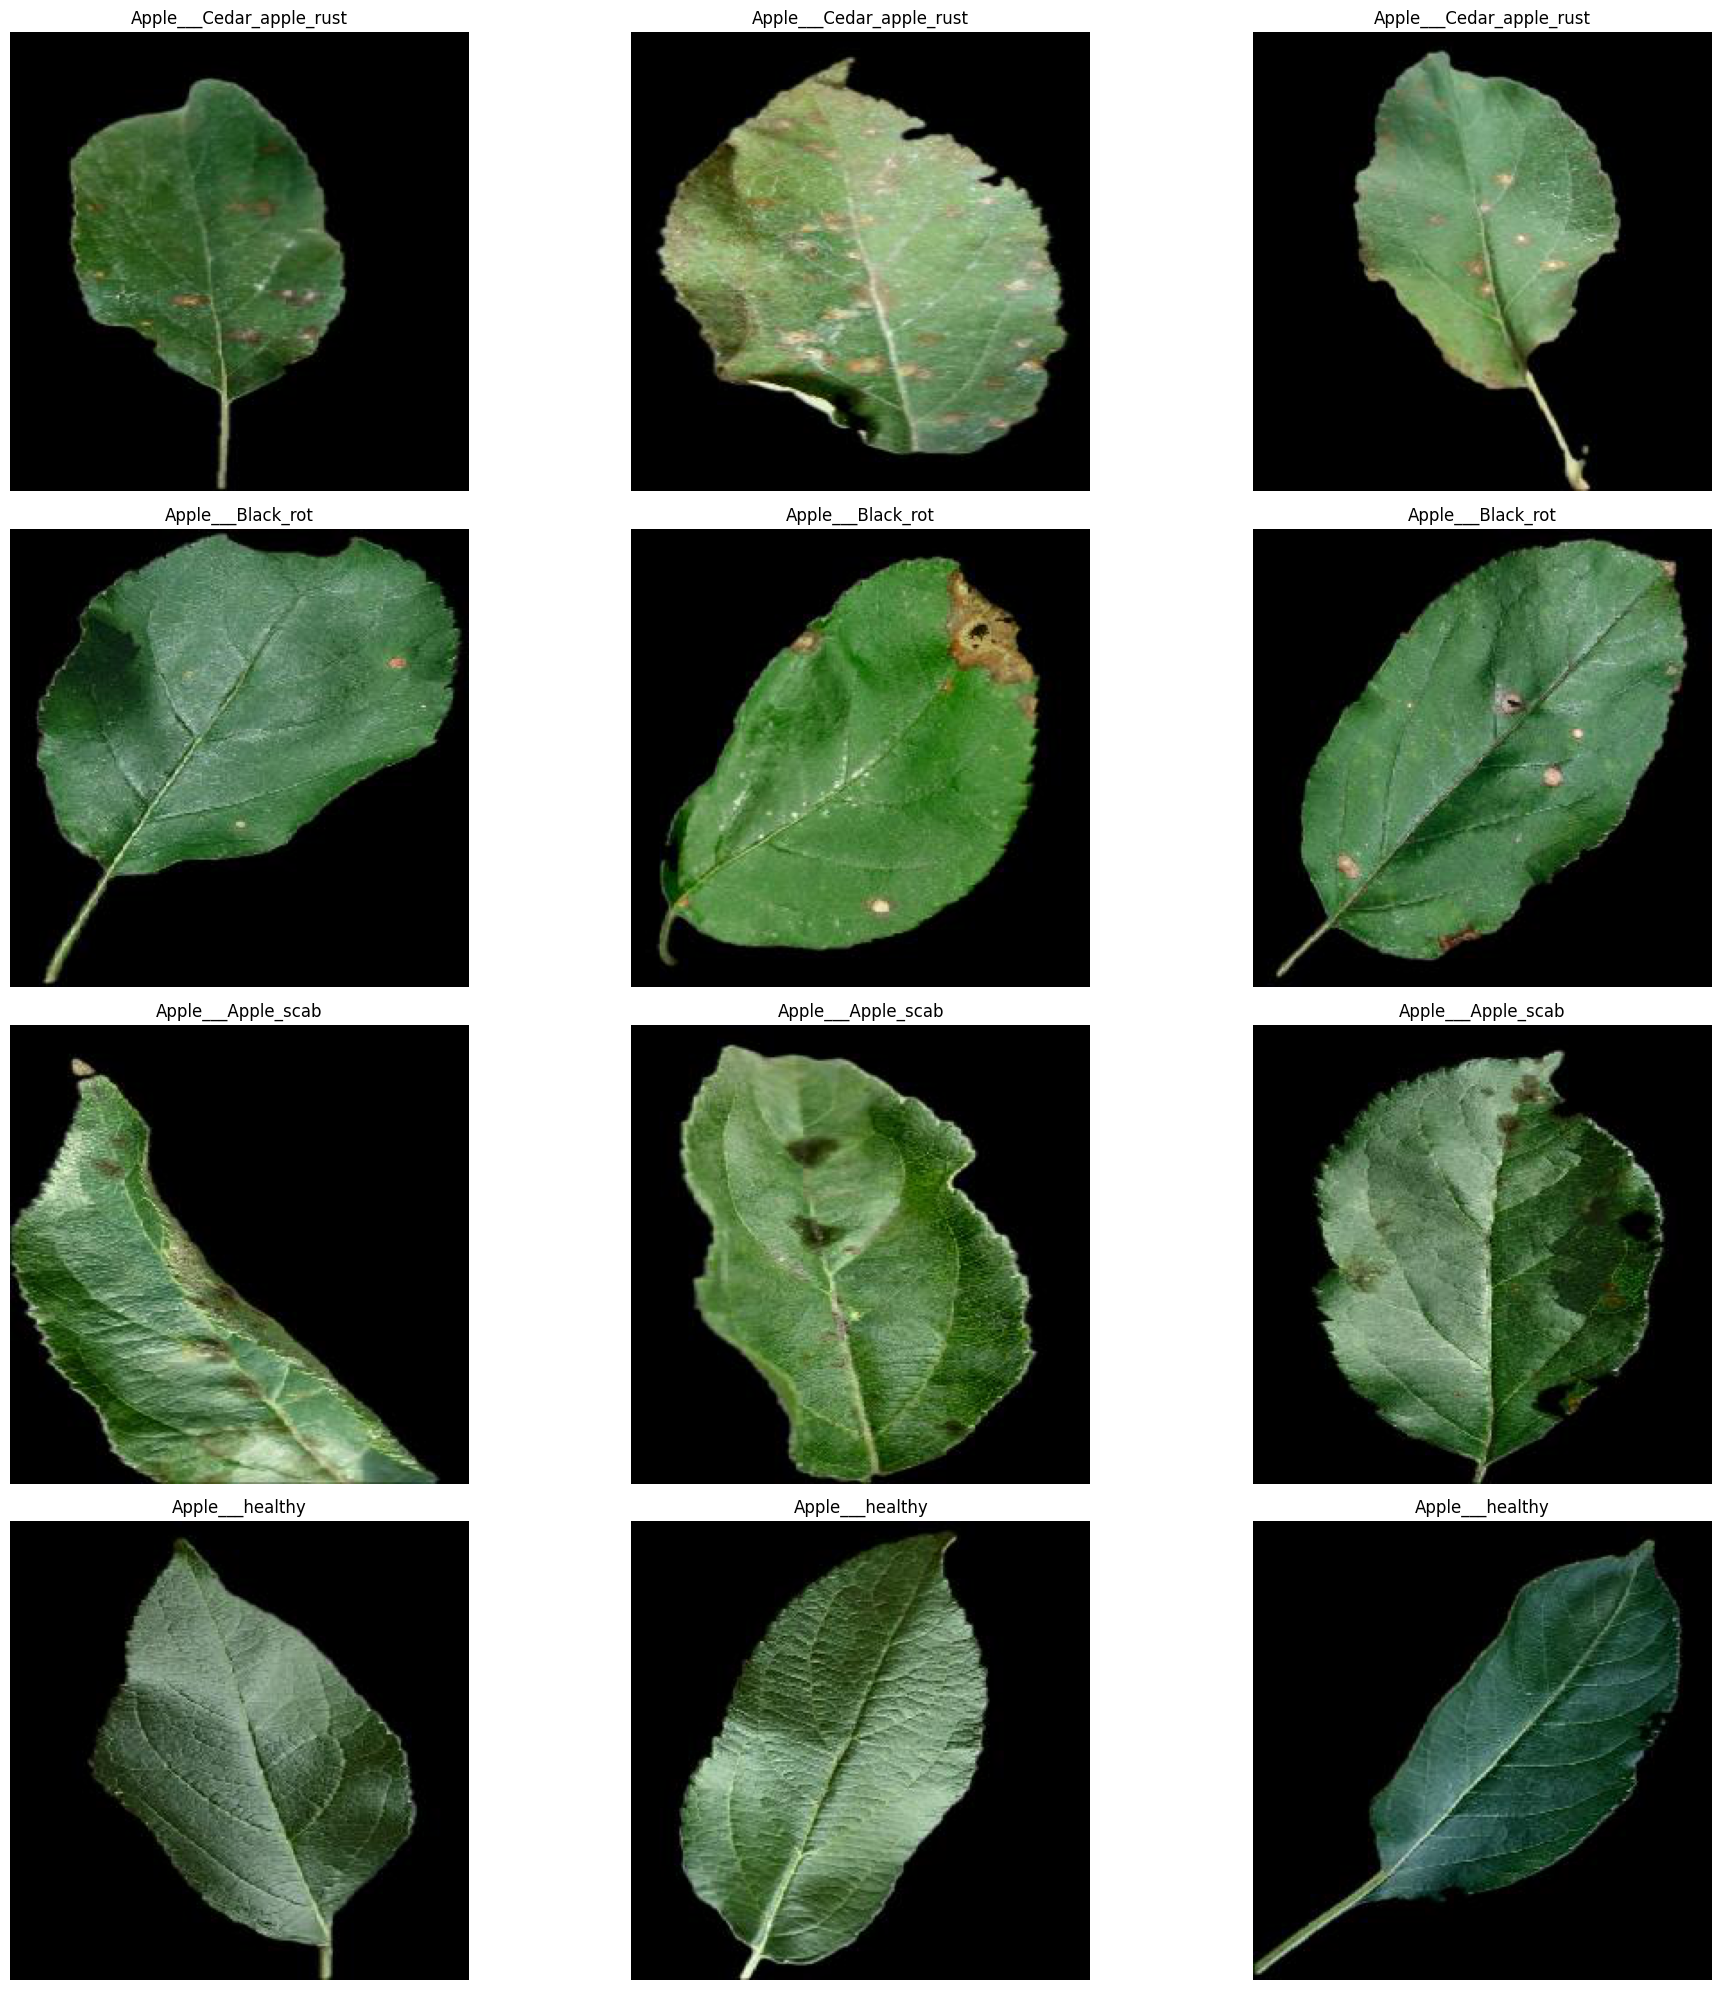

In [75]:
# Define the number of images to display per class
num_images = 3

class_names =  set(label_list)

# Loop over the subdirectories and display num_images images from each class
fig, axes = plt.subplots(len(class_names), num_images, figsize=(20,20))
for i, class_name in enumerate(class_names):
    # Define the path to the current class directory
    class_dir = os.path.join(datasetDirectory, class_name)
    
    # Get a list of the image filenames in the current class directory
    image_filenames = os.listdir(class_dir)
    
    # Select num_images random image filenames from the current class
    selected_image_filenames = np.random.choice(image_filenames, num_images, replace=False)
    
    # Loop over the selected image filenames and display the images
    for j, image_filename in enumerate(selected_image_filenames):
        # Define the path to the current image file
        image_path = os.path.join(class_dir, image_filename)
        
        # Load the image and display it using matplotlib
        image = plt.imread(image_path)
        axes[i][j].imshow(image)
        axes[i][j].axis('off')
        axes[i][j].set_title(class_name)
plt.tight_layout()
plt.show()


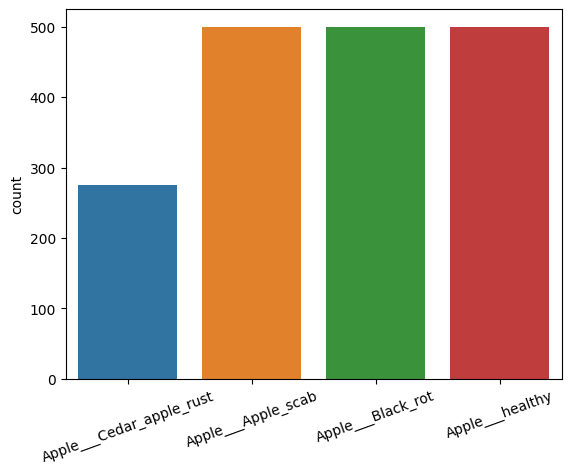

In [76]:
sns.countplot(x=label_list)
plt.xticks(rotation=20)
plt.show()

In [77]:
print(("Total number of images processing :", len(image_list)))

('Total number of images processing :', 1775)


In [78]:
# normalising images
image_list = np.array(image_list, dtype=np.float16) / 225.0

In [79]:
# encoding labels
encoder = LabelEncoder()
image_labels = encoder.fit_transform(label_list)
n_classes = len(encoder.classes_)

In [80]:
# segregating images and labels into train and test
x_train, x_test, y_train, y_test = train_test_split(image_list,
                                                    image_labels,
                                                    test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=1)

In [81]:
x_test.shape, x_train.shape

((355, 150, 150), (1136, 150, 150))

In [82]:
x_train = x_train.reshape(x_train.shape[0], 22500)
x_test = x_test.reshape(x_test.shape[0], 22500)

### Fuzzy KNN

In [83]:
def euclediandistance(data1, data2, length):
    distance=0
    for x in range(length):
        distance += np.square(data1[x]-data2[x])
    return np.sqrt(distance)

In [86]:
import scipy.spatial
from collections import Counter
from operator import itemgetter


class FKNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def getDistance(self, X1, X2):
        return scipy.spatial.distance.euclidean(X1, X2)

    def fuzzy(self, d, m):
        closestPoint = [d[k][1] for k in range(len(d))]
        classes = np.unique(self.y_train[closestPoint])
        arrMembership = []
        for cls in classes:
            atas = 0
            bawah = 0
            for close in d:
                if (close[0] != 0):
                    if (cls == self.y_train[close[1]]):
                        atas += np.power((1 / close[0]), (2 / (m - 1)))
                    else:
                        atas += np.power((0 / close[0]), (2 / (m - 1)))
                    bawah += np.power((1 / close[0]), (2 / (m - 1)))
                else:
                    atas += 0
                    bawah += 1
            arrMembership.append([atas / bawah, cls])
        return arrMembership

    def predict(self, X_test):
        final_output = []
        for i in range(len(X_test)):
            d = []
            votes = []
            for j in range(len(self.X_train)):
                dist = self.getDistance(self.X_train[j], X_test[i])
                d.append([dist, j])
            d.sort()
            d = d[0:self.k]
            membership = self.fuzzy(d, 2)
            predicted_class = sorted(membership,
                                     key=itemgetter(0),
                                     reverse=True)
            final_output.append(predicted_class[0][1])
        return final_output

    def score(self, X_test, y_test):
        predictions = self.predict(X_test)
        value = 0
        for i in range(len(y_test)):
            if (predictions[i] == y_test[i]):
                value += 1
        return value / len(y_test)

In [87]:
fknn = FKNN(9)

In [88]:
fknn.fit(x_train, y_train)

In [89]:
prediction = fknn.score(x_test, y_test)

In [90]:
print("Accuracy score: ", prediction)

Accuracy score:  0.6957746478873239


In [91]:
print((classification_report(fknn.predict(x_test), y_test)))

              precision    recall  f1-score   support

           0       0.66      0.76      0.71        85
           1       0.87      0.85      0.86        98
           2       0.43      0.49      0.46        47
           3       0.70      0.61      0.65       125

    accuracy                           0.70       355
   macro avg       0.67      0.68      0.67       355
weighted avg       0.70      0.70      0.70       355



### Multi Layer Perceptron

In [92]:
NB_EPOCH = 50
BATCH_SIZE = 128
VERBOSE = 1
NB_CLASSES = n_classes

OPTIMIZER = RMSprop() 
N_HIDDEN = 128
VALIDATION_SPLIT=0.1

DROPOUT = 0.2


In [93]:
Y_train = to_categorical(y_train, NB_CLASSES)
Y_test = to_categorical(y_test, NB_CLASSES)


In [94]:
model = Sequential()
model.add(Dense(N_HIDDEN, input_shape=(x_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(N_HIDDEN))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(NB_CLASSES))
model.add(Activation('softmax'))

In [95]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               2880128   
                                                                 
 activation_8 (Activation)   (None, 128)               0         
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 activation_9 (Activation)   (None, 128)               0         
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)              

In [96]:
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

In [97]:
history = model.fit(x_train,
                    Y_train,
                    batch_size=BATCH_SIZE,
                    epochs=NB_EPOCH,
                    verbose=VERBOSE,
                    validation_split=VALIDATION_SPLIT)

Epoch 1/50
8/8 [==============================] - 0s 24ms/step - loss: 3.6952 - accuracy: 0.3464 - val_loss: 1.0785 - val_accuracy: 0.4912
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 1.1979 - accuracy: 0.5323 - val_loss: 0.9878 - val_accuracy: 0.5789
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 1.0274 - accuracy: 0.5675 - val_loss: 0.9020 - val_accuracy: 0.6404
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.9547 - accuracy: 0.5988 - val_loss: 0.9168 - val_accuracy: 0.6228
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.9575 - accuracy: 0.6155 - val_loss: 0.8591 - val_accuracy: 0.6579
Epoch 6/50
8/8 [==============================] - 0s 17ms/step - loss: 0.9034 - accuracy: 0.6204 - val_loss: 1.1723 - val_accuracy: 0.5351
Epoch 7/50
8/8 [==============================] - 0s 17ms/step - loss: 1.0131 - accuracy: 0.5969 - val_loss: 0.9405 - val_accuracy: 0.6228
Epoch 8/50
8/8 [===========

In [98]:
score = model.evaluate(x_test, Y_test, verbose=VERBOSE)
print('Accuracy accuracy:', score[1])

12/12 [==============================] - 0s 2ms/step - loss: 1.0384 - accuracy: 0.6873
Accuracy accuracy: 0.6873239278793335


In [99]:
print((classification_report(np.argmax(model.predict(x_test), axis=1), y_test)))

12/12 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.76      0.77      0.76        96
           1       0.87      0.83      0.85       100
           2       0.43      0.50      0.46        46
           3       0.59      0.57      0.58       113

    accuracy                           0.69       355
   macro avg       0.66      0.67      0.66       355
weighted avg       0.69      0.69      0.69       355



In [100]:
# Real time Testing 
img = cv2.imread("./00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335_final_masked.jpg", 0)
#img = cv2.imread("./0ce8b939-3bdf-4078-8715-c0cb48afb078___JR_FrgE.S 2777_final_masked.jpg", 0)
output = img.copy()
img = cv2.resize(img, IMG_SIZE)
img = np.asarray(img)
image = np.array(img, dtype=np.float16) / 225.0
img = img.reshape(1, 22500)

In [101]:
label = fknn.predict(img)

/var/folders/pj/4b7g1_nd78g8fyr2mrtfzphr0000gn/T/ipykernel_40447/850670054.py:34: RuntimeWarning: invalid value encountered in double_scalars
  arrMembership.append([atas / bawah, cls])


In [102]:
np.argmax(model.predict(img))

1/1 [==============================] - 0s 31ms/step


0

In [103]:
name = encoder.inverse_transform(label)[0]

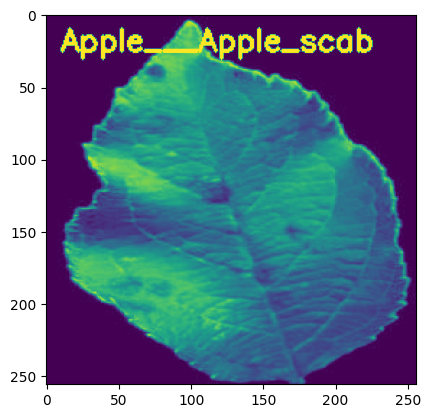

In [104]:
out = "{}".format(name)
color = (255, 0, 0)
cv2.putText(output, out, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
plt.imshow(output) #np.array(cv2.cvtColor(output, cv2.COLOR_BGR2RGB)))
plt.show()